<a href="https://colab.research.google.com/github/aaronhallaert/DeepLearningLab/blob/main/Final_Project/Deep_Learning_Final_Project_Artist_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artist Recognition
## 1. Imports and Drive Management

In [1]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import os
import re
import pickle

# fix random seed for reproducibility
seed = 2021
np.random.seed(seed)  

from sklearn.model_selection import train_test_split
from pathlib import Path
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks.experimental import BackupAndRestore

2.4.1


In [2]:
# uncomment if you want to use Drive

from google.colab import drive
drive.mount('/content/gdrive')


#!ls '/content/gdrive/My Drive/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#helper functions for visualisation

# same function as before - feel free to customize if you want!

def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.ylim([0.0,1.0])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()

## 2. Load data

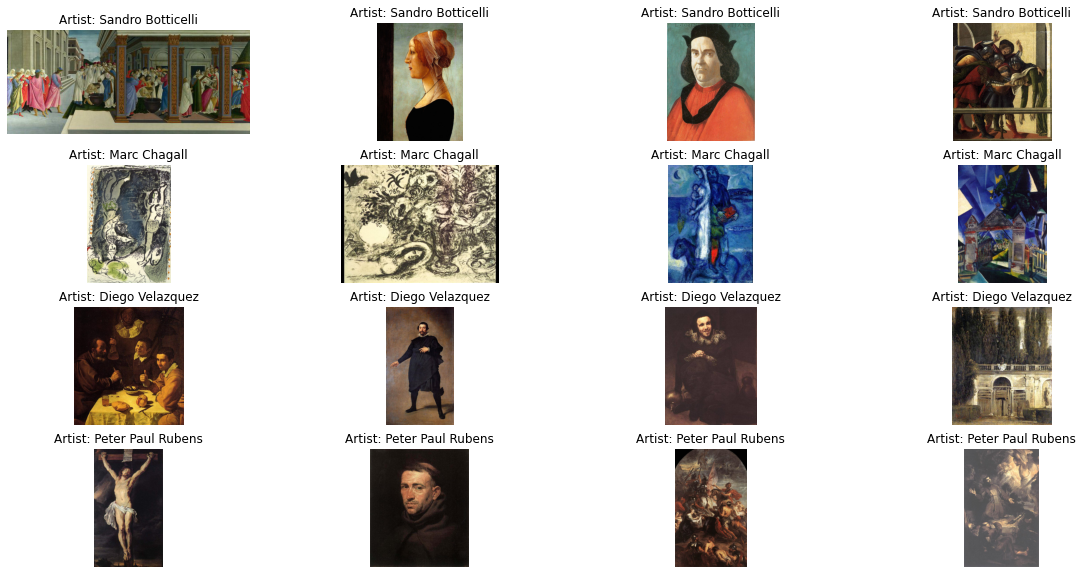

In [4]:
# resized/firstname_lastname_#.jpg
# images/firstname_lastname/firstname_lastname_#.jpg
import random
# set variables
path_to_zip = '/content/gdrive/My Drive/Colab Notebooks/DL2021/artists_recognition_dataset.zip'
local_path_to_folder = '/content/artists_recognition_dataset'
if not Path(local_path_to_folder.replace(".zip", "")).exists():
  !cp "{path_to_zip}" .
  !unzip -q artists_recognition_dataset.zip
  !rm artists_recognition_dataset.zip

path = '/content/artists_recognition_dataset/resized/resized'

images_dir = Path(path)

# key = artist:str
# value = path_to_image:Path
painting_artist_dict = {}
artist_painting_dict = {}


for image in images_dir.iterdir():
  if image.is_file():
        pattern= re.compile(r"(.*)_(\d*).jpg$")
        match = pattern.match(str(image.name))
        artist = match.group(1)
        instance = match.group(2)

        painting_artist_dict[str(image)] = artist
        if artist not in list(artist_painting_dict.keys()):
          artist_painting_dict[artist] = []
        artist_painting_dict[artist].append(image)
    
#print examples
def show_random_paintings(n_artists = 4, n_paintings = 4):
  
    fig, axes = plt.subplots(n_artists, n_paintings, figsize=(20,10))

    for r in range(n_artists):
        random_artist = random.choice(list(artist_painting_dict.keys()))
        random_images = random.sample(artist_painting_dict[random_artist], n_paintings)

        c=0
        for random_image_file in random_images:

          image = plt.imread(random_image_file)

          axes[r, c].imshow(image)
          axes[r, c].set_title("Artist: " + random_artist.replace('_', ' '))
          axes[r, c].axis('off')

          c+=1

    return plt.show()

show_random_paintings()

In [5]:
classes = list(artist_painting_dict.keys())
n_classes = len(classes)
assert n_classes == 50, "Number of classes (%d) should be 50, check Albrecht_Durer images" % n_classes

In [6]:
df_all = pd.DataFrame.from_dict(painting_artist_dict, orient= 'index')
df_all.reset_index(level=0, inplace=True)
df_all.columns = ['filename', 'label']




# Split data in train and test
X_train, X_test, y_train, y_test = train_test_split(df_all['filename'], df_all['label'], test_size=0.2, random_state=24)

print("TRAINING SPLIT")
df_train_validate = pd.concat([X_train, y_train], axis=1)
print("Training samples: %d" % df_train_validate.shape[0])

print("")
print("TEST SPLIT")
df_test = pd.concat([X_test, y_test], axis=1)
print("Test samples: %d" % df_test.shape[0])


# PARAM
train_input_shape = (128, 128, 3)
batch_size = 128

print("")
print("TRAIN / VALIDATE")
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train_validate,
    subset= "training",
    x_col = 'filename',
    y_col = 'label',
    target_size=train_input_shape[0:2],
    class_mode = 'categorical',
    shuffle=True,
    batch_size = batch_size
)

valid_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train_validate,
    subset= "validation",
    x_col = 'filename',
    y_col = 'label',
    target_size=train_input_shape[0:2],
    class_mode = 'categorical',
    shuffle=True,
    batch_size = batch_size
)

print("")
print("TEST")
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    x_col = 'filename',
    y_col = 'label',
    target_size= train_input_shape[0:2],
    class_mode = 'categorical',
    shuffle=True
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

TRAINING SPLIT
Training samples: 6684

TEST SPLIT
Test samples: 1671

TRAIN / VALIDATE
Found 5348 validated image filenames belonging to 50 classes.
Found 1336 validated image filenames belonging to 50 classes.

TEST
Found 1671 validated image filenames belonging to 50 classes.
Total number of batches = 41 and 10


## 3. Model

In [7]:
# PARAM
lr = 0.0008
def initial_model():   

  model = Sequential()

  model.add(Conv2D(128, kernel_size=(5, 5), padding='same', input_shape = train_input_shape))  
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))  
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))  
  model.add(BatchNormalization())  
  model.add(Activation('relu'))

  model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))  
  model.add(BatchNormalization())  
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(GlobalMaxPooling2D())

  model.add(Flatten())
  model.add(Dense(n_classes))
  model.add(Activation('softmax'))

  opt = tf.keras.optimizers.Adam(learning_rate=lr)

  model.compile(loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy'])

  return model


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

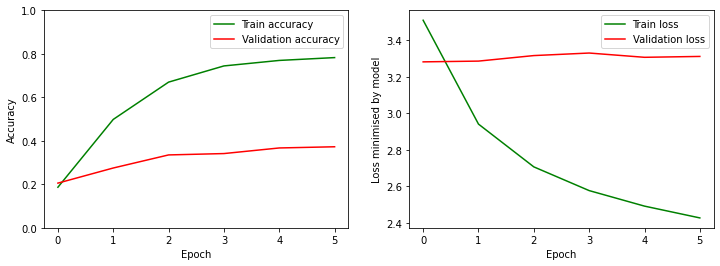

In [11]:
# PARAM
n_epoch = 30

checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/DL2021/Final Project/"
best_model_savename = checkpoint_dir+"best_model.h5"
monitor = 'val_accuracy'

# CALLBACKS
best_cp_callback = ModelCheckpoint(best_model_savename,
                                   monitor=monitor,
                                   save_weights_only=False,
                                   save_best_only=True,
                                   verbose=1)

backup_callback = BackupAndRestore(checkpoint_dir + "backup/")

stopping_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1, 
                           mode='auto', restore_best_weights=True)

history_callback = HistoryCheckpoint(checkpoint_dir + "history.pi", 
                                     monitor=monitor)

# CREATE MODEL
model = example_model()
# model = initial_model()
model.summary()

# START TRAINING
try:
  # Try to resume from a history.
  history_callback.load_history()

  # Set the best value from this history in the 'best model' callback.
  if best_cp_callback.monitor_op == np.less:
    best_cp_callback.best = np.min(history_callback.history[monitor])
  if best_cp_callback.monitor_op == np.greater:
    best_cp_callback.best = np.max(history_callback.history[monitor])
  print(f"History with {len(history_callback.epoch)} epochs loaded!")
except OSError:
  print("No history found, starting new logs!")

model.fit(train_generator, steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data=valid_generator, validation_steps = STEP_SIZE_VALID,
          epochs=n_epoch,
          shuffle=True,
          verbose=2,
          callbacks=[history_callback, backup_callback, stopping_callback, best_cp_callback]
          )
history = history_callback

[train_loss, train_accuracy] = model.evaluate(train_generator, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model.evaluate(valid_generator, verbose=0)
print("Validation set Accuracy:{:7.2f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))



plot_history(history)

In [12]:
# Normally, the backup is deleted automatically after all training epochs have ended. 
# Executing this command forces the deletion even if the training is not done yet.
!rm -r "{checkpoint_dir + "backup/"}"
#!rm -r "{checkpoint_dir + "checkpoints/"}"

# Again, the history will be removed after a full training run automatically,
# but you can force the history to be deleted to be sure:
!rm -r "{checkpoint_dir + "history.pi"}"

rm: cannot remove '/content/gdrive/My Drive/Colab Notebooks/DL2021/Final Project/history.pi': No such file or directory


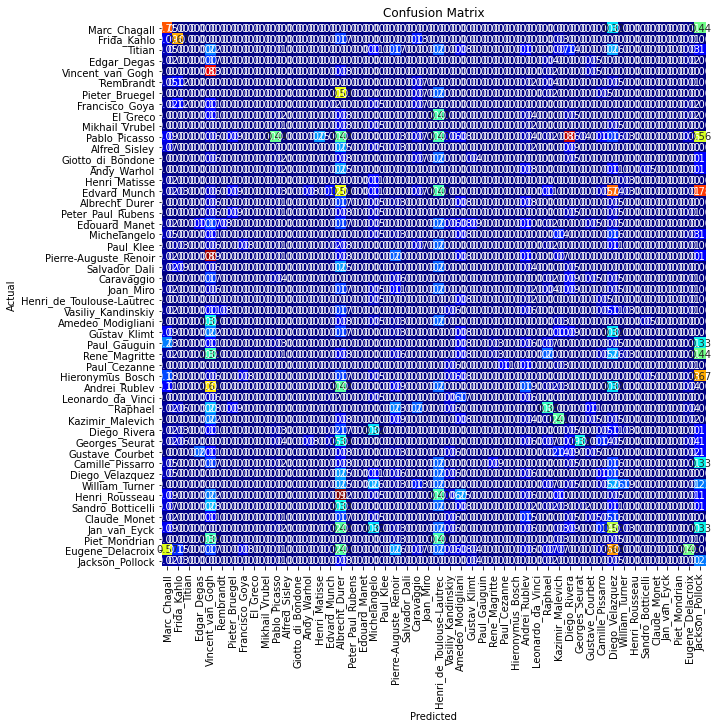

Classification Report:
                           precision    recall  f1-score   support

             Marc_Chagall       0.25      0.75      0.38        44
              Frida_Kahlo       0.48      0.67      0.56        33
                   Titian       0.00      0.00      0.00        37
              Edgar_Degas       0.00      0.00      0.00        10
         Vincent_van_Gogh       0.12      0.83      0.20        18
                Rembrandt       0.00      0.00      0.00        12
           Pieter_Bruegel       0.00      0.00      0.00        11
           Francisco_Goya       0.00      0.00      0.00        13
                 El_Greco       0.00      0.00      0.00        13
           Mikhail_Vrubel       0.00      0.00      0.00         5
            Pablo_Picasso       0.56      0.44      0.49       108
            Alfred_Sisley       0.00      0.00      0.00        11
        Giotto_di_Bondone       0.00      0.00      0.00         9
              Andy_Warhol       0.00  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = classes

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)

    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=classes))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

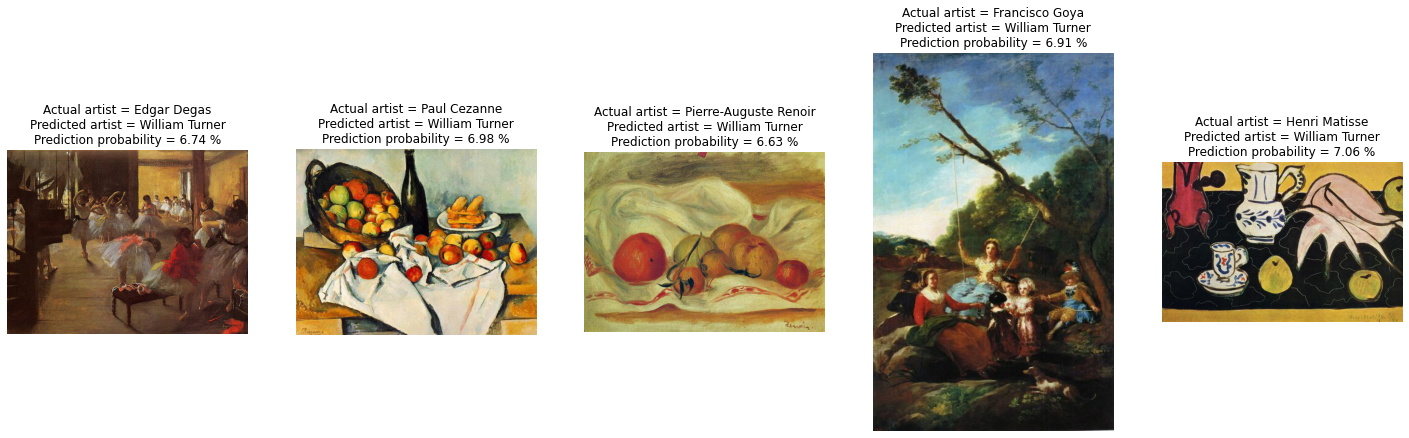

In [14]:
# Prediction
from keras.preprocessing import *
from PIL import Image

n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_artist = random.choice(list(artist_painting_dict.keys()))
    random_image_file = random.choice(artist_painting_dict[random_artist])

    test_image = Image.open(random_image_file) 
    test_image = test_image.resize(train_input_shape[0:2])

    test_image = np.array(test_image)
    test_image = test_image / 255.0
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

In [15]:
[test_loss, test_accuracy] = model.evaluate(test_generator, verbose=0)
print("Test set Accuracy:{:7.2f}".format(test_accuracy))
print("Test set Loss:{:7.4f}\n".format(test_loss))

Test set Accuracy:   0.21
Test set Loss: 3.2300

